In [1]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, dump
from surprise.model_selection import train_test_split

# Détermine dynamiquement le chemin racine du projet
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # remonte depuis notebooks/

# Définition des chemins des dossiers racine
outputs_dir = Path(project_root) / "outputs"
models_dir = Path(project_root) / "models"

print(f"Chemins configurés :\n- outputs/ = {outputs_dir}\n- models/ = {models_dir}")

Chemins configurés :
- outputs/ = c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\outputs
- models/ = c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\models


# 1 - CONFIGURATION DE L'ÉCHANTILLONNAGE INTELLIGENT

In [2]:
MIN_CLICKS_PER_USER = 4     # Minimum de clics par utilisateur
TARGET_USERS = 1500         # Nombre d'utilisateurs à conserver
TARGET_TOTAL_LINES = 5000   # Nombre total de lignes cible
RANDOM_STATE = 70           # Pour reproductibilité

print(f"PARAMÈTRES D'ÉCHANTILLONNAGE INTELLIGENT")
print(f"   - Minimum {MIN_CLICKS_PER_USER} clics par utilisateur")
print(f"   - Objectif {TARGET_USERS} utilisateurs")
print(f"   - Objectif {TARGET_TOTAL_LINES} lignes totales")

PARAMÈTRES D'ÉCHANTILLONNAGE INTELLIGENT
   - Minimum 4 clics par utilisateur
   - Objectif 1500 utilisateurs
   - Objectif 5000 lignes totales


# 2 - Définition des chemins des fichiers d'entrée
## 2.1 - complets

In [3]:
df_path = outputs_dir / "df.parquet"
df_articles_path = outputs_dir / "df_articles.parquet"

## 2.2 - réduits

In [4]:
df_light_path = outputs_dir / "df_light.parquet"
df_articles_light_path = outputs_dir / "df_articles_light.parquet"

## 2.3 -  Chemin vers le modèle CF allégé

In [5]:
model_cf_light_path = models_dir / "model_cf_light.pkl"

## 2.4 - Chemin vers le fichier user_ids valides

In [6]:
user_ids_path = outputs_dir / "user_ids_valid.json"

# 3 - Chargement des fichiers complets

In [7]:
print(f"Chargement des données complètes...")
df = pd.read_parquet(df_path)
df_articles = pd.read_parquet(df_articles_path)

print(f"   Dataset original : {len(df):,} lignes, {df['user_id'].nunique():,} utilisateurs")
print(f"   Articles totaux : {len(df_articles):,}")

Chargement des données complètes...
   Dataset original : 2,988,181 lignes, 322,897 utilisateurs
   Articles totaux : 364,047


# 4 - ANALYSE DE LA DISTRIBUTION DES CLICS

In [8]:
print(f"ANALYSE DE LA DISTRIBUTION DES CLICS")
user_clicks = df.groupby('user_id').size().reset_index()
user_clicks.columns = ['user_id', 'nb_clicks']

print(f"   Utilisateurs totaux : {len(user_clicks):,}")
print(f"   Clics par utilisateur - Médiane : {user_clicks['nb_clicks'].median():.1f}")
print(f"   Clics par utilisateur - Moyenne : {user_clicks['nb_clicks'].mean():.1f}")

print(f"Distribution par nombre de clics (top 15) :")
distribution = user_clicks['nb_clicks'].value_counts().sort_index().head(15)
for nb_clicks, count in distribution.items():
    percentage = (count / len(user_clicks)) * 100
    print(f"   {nb_clicks:2d} clics : {count:5d} utilisateurs ({percentage:5.1f}%)")

ANALYSE DE LA DISTRIBUTION DES CLICS
   Utilisateurs totaux : 322,897
   Clics par utilisateur - Médiane : 4.0
   Clics par utilisateur - Moyenne : 9.3
Distribution par nombre de clics (top 15) :
    2 clics : 101428 utilisateurs ( 31.4%)
    3 clics : 22660 utilisateurs (  7.0%)
    4 clics : 38432 utilisateurs ( 11.9%)
    5 clics : 18070 utilisateurs (  5.6%)
    6 clics : 20370 utilisateurs (  6.3%)
    7 clics : 13358 utilisateurs (  4.1%)
    8 clics : 12780 utilisateurs (  4.0%)
    9 clics :  9701 utilisateurs (  3.0%)
   10 clics :  8807 utilisateurs (  2.7%)
   11 clics :  7143 utilisateurs (  2.2%)
   12 clics :  6485 utilisateurs (  2.0%)
   13 clics :  5500 utilisateurs (  1.7%)
   14 clics :  4990 utilisateurs (  1.5%)
   15 clics :  4284 utilisateurs (  1.3%)
   16 clics :  3787 utilisateurs (  1.2%)


# 5 - SÉLECTION INTELLIGENTE DES UTILISATEURS

In [9]:
print(f"SÉLECTION INTELLIGENTE (min {MIN_CLICKS_PER_USER} clics)")
users_enough_clicks = user_clicks[user_clicks['nb_clicks'] >= MIN_CLICKS_PER_USER]
print(f"   Utilisateurs avec ≥{MIN_CLICKS_PER_USER} clics : {len(users_enough_clicks):,}")

SÉLECTION INTELLIGENTE (min 4 clics)
   Utilisateurs avec ≥4 clics : 198,809


## 5.1 - Ajustement du seuil si nécessaire

In [10]:
if len(users_enough_clicks) < TARGET_USERS:
    print(f"Pas assez d'utilisateurs avec ≥{MIN_CLICKS_PER_USER} clics")
    MIN_CLICKS_PER_USER = max(1, MIN_CLICKS_PER_USER - 1)
    print(f"   Réduction du seuil à {MIN_CLICKS_PER_USER} clics")
    users_enough_clicks = user_clicks[user_clicks['nb_clicks'] >= MIN_CLICKS_PER_USER]

# 6 - ÉCHANTILLONNAGE STRATIFIÉ

In [11]:
print(f"ÉCHANTILLONNAGE STRATIFIÉ")

ÉCHANTILLONNAGE STRATIFIÉ


## 6.1 - Créer des strates par nombre de clics

In [12]:
users_enough_clicks['strate'] = pd.cut(
    users_enough_clicks['nb_clicks'], 
    bins=[MIN_CLICKS_PER_USER-1, 5, 10, 20, 50, float('inf')], 
    labels=[f'{MIN_CLICKS_PER_USER}-5 clics', '6-10 clics', '11-20 clics', '21-50 clics', '50+ clics'],
    include_lowest=True
)

print("   Répartition par strates :")
strate_counts = users_enough_clicks['strate'].value_counts()
for strate, count in strate_counts.items():
    print(f"   {strate} : {count:,} utilisateurs")

   Répartition par strates :
   6-10 clics : 65,016 utilisateurs
   4-5 clics : 56,502 utilisateurs
   11-20 clics : 43,999 utilisateurs
   21-50 clics : 26,927 utilisateurs
   50+ clics : 6,365 utilisateurs


C:\Users\motar\AppData\Local\Temp\ipykernel_39704\2462343955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_enough_clicks['strate'] = pd.cut(


## 6.2 - Échantillonnage proportionnel par strate

In [13]:
selected_users = []
remaining_target = min(TARGET_USERS, len(users_enough_clicks))

for strate in users_enough_clicks['strate'].cat.categories:
    strate_users = users_enough_clicks[users_enough_clicks['strate'] == strate]
    if len(strate_users) == 0:
        continue
        
    # Proportion de cette strate
    proportion = len(strate_users) / len(users_enough_clicks)
    target_for_strate = min(int(remaining_target * proportion), len(strate_users))
    
    if target_for_strate > 0:
        sampled = strate_users.sample(n=target_for_strate, random_state=RANDOM_STATE)
        selected_users.append(sampled)
        remaining_target -= target_for_strate
        print(f"   {strate} : {target_for_strate:,} utilisateurs sélectionnés")

   4-5 clics : 426 utilisateurs sélectionnés
   6-10 clics : 351 utilisateurs sélectionnés
   11-20 clics : 160 utilisateurs sélectionnés
   21-50 clics : 76 utilisateurs sélectionnés
   50+ clics : 15 utilisateurs sélectionnés


## 6.3 - Combiner tous les utilisateurs sélectionnés

In [14]:
selected_users_df = pd.concat(selected_users, ignore_index=True)
selected_user_ids = selected_users_df['user_id'].tolist()

print(f"Utilisateurs finalement sélectionnés : {len(selected_user_ids):,}")

Utilisateurs finalement sélectionnés : 1,028


### Répartition des strates d’utilisateurs (avant vs après échantillonnage)
Comparaison de la répartition des utilisateurs par strate de clics avant et après échantillonnage, pour vérifier la représentativité conservée.

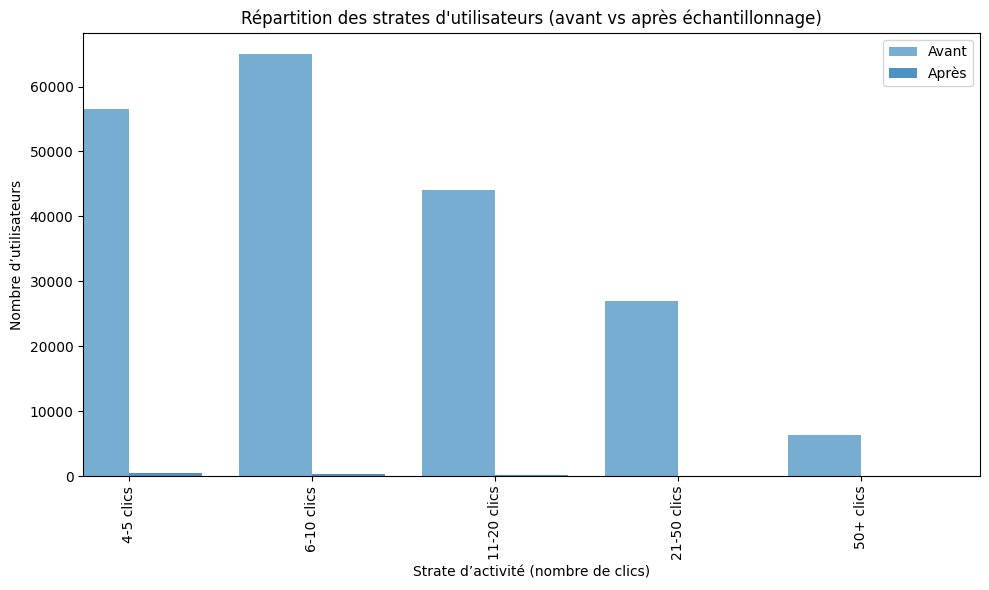

In [32]:
import matplotlib.pyplot as plt

# Répartition des strates (avant vs après)
plt.figure(figsize=(10, 6))

users_enough_clicks['strate'].value_counts().sort_index().plot(
    kind="bar", alpha=0.6, label="Avant", width=0.4, position=1
)

selected_users_df['strate'].value_counts().sort_index().plot(
    kind="bar", alpha=0.8, label="Après", width=0.4, position=0
)

plt.title("Répartition des strates d'utilisateurs (avant vs après échantillonnage)")
plt.xlabel("Strate d’activité (nombre de clics)")
plt.ylabel("Nombre d’utilisateurs")
plt.legend()
plt.tight_layout()
plt.show()


# 7 - CRÉATION DU DF_LIGHT INTELLIGENT

In [15]:
print(f"CRÉATION DU DF_LIGHT OPTIMISÉ")
df_light = df[df['user_id'].isin(selected_user_ids)].copy()

print(f"   Lignes dans df_light : {len(df_light):,}")
print(f"   Utilisateurs dans df_light : {df_light['user_id'].nunique():,}")
print(f"   Articles uniques : {df_light['article_id'].nunique():,}")

CRÉATION DU DF_LIGHT OPTIMISÉ
   Lignes dans df_light : 10,342
   Utilisateurs dans df_light : 1,028
   Articles uniques : 2,498


## 7.1 - Vérification de la nouvelle distribution

In [16]:
new_user_clicks = df_light.groupby('user_id').size()
print(f"NOUVELLE DISTRIBUTION APRÈS ÉCHANTILLONNAGE")
print(f"   Clics par utilisateur - Médiane : {new_user_clicks.median():.1f}")
print(f"   Clics par utilisateur - Moyenne : {new_user_clicks.mean():.1f}")
print(f"   Min clics : {new_user_clicks.min()}")
print(f"   Max clics : {new_user_clicks.max()}")

NOUVELLE DISTRIBUTION APRÈS ÉCHANTILLONNAGE
   Clics par utilisateur - Médiane : 6.0
   Clics par utilisateur - Moyenne : 10.1
   Min clics : 4
   Max clics : 148


In [17]:
print(f"Distribution finale des clics par utilisateur (top 15) :")
final_distribution = new_user_clicks.value_counts().sort_index().head(15)
for nb_clicks, count in final_distribution.items():
    percentage = (count / len(new_user_clicks)) * 100
    print(f"   {nb_clicks:2d} clics : {count:4d} utilisateurs ({percentage:5.1f}%)")


Distribution finale des clics par utilisateur (top 15) :
    4 clics :  275 utilisateurs ( 26.8%)
    5 clics :  151 utilisateurs ( 14.7%)
    6 clics :  124 utilisateurs ( 12.1%)
    7 clics :   61 utilisateurs (  5.9%)
    8 clics :   70 utilisateurs (  6.8%)
    9 clics :   49 utilisateurs (  4.8%)
   10 clics :   47 utilisateurs (  4.6%)
   11 clics :   23 utilisateurs (  2.2%)
   12 clics :   26 utilisateurs (  2.5%)
   13 clics :   22 utilisateurs (  2.1%)
   14 clics :   20 utilisateurs (  1.9%)
   15 clics :   16 utilisateurs (  1.6%)
   16 clics :   14 utilisateurs (  1.4%)
   17 clics :    8 utilisateurs (  0.8%)
   18 clics :    5 utilisateurs (  0.5%)


# 8 - GESTION DES ARTICLES

In [18]:
print(f"GESTION DES ARTICLES")
article_ids_in_df_light = df_light["article_id"].unique()
print(f"Articles cliqués dans df_light : {len(article_ids_in_df_light):,}")

GESTION DES ARTICLES
Articles cliqués dans df_light : 2,498


## 8.1 - Conservation des articles cliqués + complément aléatoire

In [19]:
df_articles_clicked = df_articles[df_articles["article_id"].isin(article_ids_in_df_light)]
print(f"Articles avec métadonnées : {len(df_articles_clicked):,}")

Articles avec métadonnées : 2,498


In [20]:
nb_to_add = 2000 - len(df_articles_clicked)
if nb_to_add > 0:
    df_articles_rest = df_articles[~df_articles["article_id"].isin(article_ids_in_df_light)]
    if len(df_articles_rest) >= nb_to_add:
        df_articles_extra = df_articles_rest.sample(n=nb_to_add, random_state=RANDOM_STATE)
        df_articles_light = pd.concat([df_articles_clicked, df_articles_extra])
        print(f"   Ajout de {nb_to_add:,} articles complémentaires")
    else:
        df_articles_light = pd.concat([df_articles_clicked, df_articles_rest])
        print(f"   Ajout de tous les articles restants : {len(df_articles_rest):,}")
else:
    df_articles_light = df_articles_clicked

print(f"   Total articles dans df_articles_light : {len(df_articles_light):,}")

   Total articles dans df_articles_light : 2,498


# 9 - SAUVEGARDE DES FICHIERS OPTIMISÉS

In [21]:
print(f"SAUVEGARDE DES FICHIERS")
df_light.to_parquet(df_light_path, index=False)
df_articles_light.to_parquet(df_articles_light_path, index=False)
print(f"{df_light_path}")
print(f"{df_articles_light_path}")

SAUVEGARDE DES FICHIERS
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\outputs\df_light.parquet
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\outputs\df_articles_light.parquet


# 10 - GÉNÉRATION DU FICHIER USER_IDS_VALID.JSON

In [22]:
valid_user_ids = sorted(df_light['user_id'].unique().tolist())
with open(user_ids_path, 'w', encoding='utf-8') as f:
    json.dump(valid_user_ids, f, indent=2)
print(f"{user_ids_path} - {len(valid_user_ids):,} utilisateurs")

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\outputs\user_ids_valid.json - 1,028 utilisateurs


# 11 - PRÉPARATION POUR SURPRISE ET ENTRAÎNEMENT 
- Le DataFrame df_light doit contenir : user_id, article_id, click (implicite)
- Création d'une colonne de rating implicite = 1 (car clic = interaction)

In [23]:
print(f"ENTRAÎNEMENT DU MODÈLE CF")
df_light["click"] = 1

ENTRAÎNEMENT DU MODÈLE CF


## 11.1 - Création du reader Surprise

In [24]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df_light[["user_id", "article_id", "click"]], reader)

## 11.2 - Split train/test (utile même pour entraînement simple → cohérence API)

In [25]:
trainset, _ = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)

## 11.3 - Entraînement du modèle CF (SVD)

In [26]:
model = SVD(n_factors=20, random_state=RANDOM_STATE)
model.fit(trainset)

## 11.4 - Sauvegarde du modèle entraîné (version allégée)

In [27]:
dump.dump(model_cf_light_path, predictions=None, algo=model)
print(f"Modèle CF sauvegardé : {model_cf_light_path}")

Modèle CF sauvegardé : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\models\model_cf_light.pkl


## 12 - RAPPORT FINAL

In [28]:
print(f"RAPPORT FINAL")
print(f"   Dataset original : {len(df):,} lignes, {df['user_id'].nunique():,} utilisateurs")
print(f"   Dataset optimisé : {len(df_light):,} lignes, {df_light['user_id'].nunique():,} utilisateurs")
print(f"   Réduction : {len(df_light)/len(df)*100:.1f}% des lignes conservées")
print(f"   Clics minimum par utilisateur : {new_user_clicks.min()}")
print(f"   Clics maximum par utilisateur : {new_user_clicks.max()}")
print(f"   Articles avec métadonnées : {len(df_articles_light):,}")

print(f"\n✅ TERMINÉ !")
print(f"   📁 df_light.parquet : {len(df_light):,} lignes avec utilisateurs actifs")
print(f"   📁 df_articles_light.parquet : {len(df_articles_light):,} articles")
print(f"   📁 model_cf_light.pkl : modèle entraîné sur données qualitatives")
print(f"   📁 user_ids_valid.json : {len(valid_user_ids):,} utilisateurs valides")

RAPPORT FINAL
   Dataset original : 2,988,181 lignes, 322,897 utilisateurs
   Dataset optimisé : 10,342 lignes, 1,028 utilisateurs
   Réduction : 0.3% des lignes conservées
   Clics minimum par utilisateur : 4
   Clics maximum par utilisateur : 148
   Articles avec métadonnées : 2,498

✅ TERMINÉ !
   📁 df_light.parquet : 10,342 lignes avec utilisateurs actifs
   📁 df_articles_light.parquet : 2,498 articles
   📁 model_cf_light.pkl : modèle entraîné sur données qualitatives
   📁 user_ids_valid.json : 1,028 utilisateurs valides


### Réduction du dataset
Illustration de la compression du jeu de données d’origine vers la version allégée `df_light`.

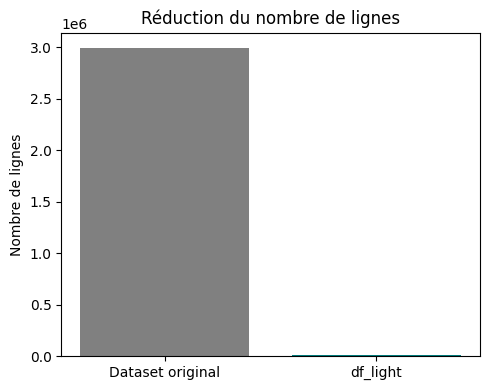

In [33]:
plt.figure(figsize=(5, 4))
plt.bar(["Dataset original", "df_light"], [len(df), len(df_light)], color=["gray", "teal"])
plt.title("Réduction du nombre de lignes")
plt.ylabel("Nombre de lignes")
plt.tight_layout()
plt.show()


# 13 - VÉRIFICATION RAPIDE

In [29]:
print(f"VÉRIFICATION")
test_df = pd.read_parquet(df_light_path)
test_user_clicks = test_df.groupby('user_id').size()
print(f"   Utilisateurs dans le fichier final : {test_df['user_id'].nunique():,}")
print(f"   Clics min/max : {test_user_clicks.min()}/{test_user_clicks.max()}")
print(f"   Exemples d'utilisateurs : {test_df['user_id'].unique()[:5].tolist()}")

VÉRIFICATION
   Utilisateurs dans le fichier final : 1,028
   Clics min/max : 4/148
   Exemples d'utilisateurs : [8, 96, 330, 397, 452]
